## OCR Comparison for French Historical Newspapers

### Import libraries


In [ ]:
#imports 
import os
import glob
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import subprocess

import json
import math

from typing import Callable, Dict, List

import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoModelForMaskedLM, AutoTokenizer
import math


from kraken.lib.models import load_any
from transformers import AutoModelForMaskedLM, AutoTokenizer
import enchant

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

### Set up and helper functions

In [ ]:
IMAGE_DIR = "samples_from_selected_list_of_french_newspapers"

# Tesseract: using French (“fra”) OCR model for data from Gallica
TESS_LANG = "fra"

# using Kraken default model
KRAKEN_MODEL = "models/catmus-print-fondue-large.mlmodel"

In [11]:
kraken_model = load_any(KRAKEN_MODEL)

In [ ]:
def ocr_kraken(img_path):
    """ OCR using Kraken.
    """
    
    img_path = Path(img_path).resolve()
    ws_dir   = img_path.parent / f"{img_path.stem}_kraken_ws"
    ws_dir.mkdir(exist_ok=True)

    out_txt = ws_dir / f"{img_path.stem}_kraken.txt"
    if out_txt.exists():
        return out_txt                    # already processed

    cmd = [
        "kraken", "-i", str(img_path), str(out_txt),
        "binarize", "segment", "-bl", "-d", "horizontal-lr",
        "ocr", "-m", KRAKEN_MODEL
    ]

    if subprocess.run(cmd).returncode != 0 or not out_txt.exists():
        print(f"Kraken failed on {img_path.name}")
        return None

    return out_txt


def ocr_ocrd_tesseract_calamari(img_path):
	img_path = Path(img_path).resolve()
	ws_dir = img_path.parent / f"{img_path.stem}_ocrd_ws"
	ws_dir.mkdir(exist_ok=True)

	# ------------------------------------------------------------------
	# phase 0  – workspace + image
	# ------------------------------------------------------------------
	if not (ws_dir / "mets.xml").exists():
		subprocess.run(["ocrd", "workspace", "--directory", ws_dir, "init"],
					   check=True)

	subprocess.run([
		"ocrd", "workspace", "--directory", ws_dir,
		"add", "-g", "PAGE1", "-i", "OCR-D-IMG_PAGE1",
		"-m", "image/tiff", "-G", "OCR-D-IMG", "--force",
		str(img_path)
	], check=True)

	# ------------------------------------------------------------------
	# phase 1  – binarise + segment (shared for both engines)
	# ------------------------------------------------------------------
	subprocess.run(["ocrd-olena-binarize",
					"-I", "OCR-D-IMG", "-O", "OCR-D-BIN", "--overwrite"],
				   cwd=ws_dir, check=True)

	subprocess.run(["ocrd-tesserocr-segment",
					"-I", "OCR-D-BIN", "-O", "OCR-D-SEG", "--overwrite"],
				   cwd=ws_dir, check=True)

	# ------------------------------------------------------------------
	# phase 2a – recognise with Tesseract
	# ------------------------------------------------------------------
	subprocess.run([
		"ocrd-tesserocr-recognize",
		"-I", "OCR-D-SEG", "-O", "OCR-D-OCR-TESSEROCR",
		"-p", '{"model": "fra+Latin+Fraktur"}',
		"--overwrite"
	], cwd=ws_dir, check=True)

	subprocess.run([
		"ocrd-fileformat-transform",
		"-I", "OCR-D-OCR-TESSEROCR", "-O", "OCR-D-TXT",
		"-P", "from-to", "page text", "--overwrite"
	], cwd=ws_dir, check=True)

	# ------------------------------------------------------------------
	# phase 2b – recognise with Calamari
	# ------------------------------------------------------------------
	subprocess.run([
		"conda", "run", "-n", "ds-calamari",
		"ocrd-calamari-recognize",
		"-I", "OCR-D-SEG", "-O", "OCR-D-OCR-CALAMARI",
		"-P", "checkpoint_dir", "historical_french",
		"--overwrite"
	], cwd=ws_dir, check=True)

	subprocess.run([
		"ocrd-fileformat-transform",
		"-I", "OCR-D-OCR-CALAMARI", "-O", "OCR-D-TXT-CALAMARI",
		"-P", "from-to", "page text", "--overwrite"
	], cwd=ws_dir, check=True)

	# ------------------------------------------------------------------
	# Collect output paths
	# ------------------------------------------------------------------
	tesseract_txt = ws_dir / "OCR-D-TXT" / "OCR-D-TXT_PAGE1.txt"
	calamari_txt = ws_dir / "OCR-D-TXT-CALAMARI" / "OCR-D-TXT-CALAMARI_PAGE1.txt"

	return tesseract_txt, calamari_txt

In [6]:
image_paths = sorted(
    glob.glob(os.path.join(IMAGE_DIR, "*.*")),
    key=lambda p: p.lower()
)
image_paths = [Path(p) for p in image_paths if p.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]

if not image_paths:
    raise FileNotFoundError(f"No images found in {IMAGE_DIR}")




### Run OCRs

In [ ]:
text_results_paths = []

for img_path in image_paths:
    print(f"Processing {img_path}")
    
    tess_txt, cala_txt = ocr_ocrd_tesseract_calamari(img_path)  # 2-tuple
    kraken_txt         = ocr_kraken(img_path)
    
    text_results_paths.append({
        "image":        img_path.name,
        "tesseract":    tess_txt,
        "kraken":       kraken_txt,
        "ocrd_calamari": cala_txt,
    })

### Perplexity and OOV rate calculation

In [ ]:
hf_model_id = "camembert-base"
device      = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Loading {hf_model_id} on {device} …")
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model     = AutoModelForMaskedLM.from_pretrained(hf_model_id).to(device)
model.eval()


def sliding_windows(tokens, max_len, stride):
    for start in range(0, len(tokens), stride):
        window = tokens[start : start + max_len]
        if len(window) < max_len:
            break
        yield window

def perplexity(text: str, max_len=256, stride=128) -> float:
    enc = tokenizer(text, return_tensors="pt")["input_ids"][0]
    losses = []
    with torch.no_grad():
        for window in sliding_windows(enc, max_len, stride):
            inputs   = window.unsqueeze(0).to(device)
            labels   = inputs.clone()
            outputs  = model(inputs, labels=labels)
            loss     = outputs.loss.item()
            losses.append(loss)
    if sum(losses) == 0 or len(losses) == 0:
        return float("inf")
    return math.exp(sum(losses) / len(losses))



fr_dict = enchant.Dict("fr_FR")

def get_oov_rate(text: str) -> float:
    words = text.split()
    if len(words) == 0:
        return float("inf")  # no words, return infinity
    oov = sum(1 for w in words if not fr_dict.check(w))
    if oov == 0:
        return float("inf")  # no OOV words, return infinity
    return oov / len(words)
records = []

def get_iv_rate(text: str):
    words = text.split()
    if len(words) == 0:
        return float("inf"), 0  # no words, return infinity and 0
    iv = sum(1 for w in words if fr_dict.check(w))
    if iv == 0:
        return float("inf"), 0  # no in-vocabulary words, return infinity and 0
    return iv / len(words), iv


NameError: name 'torch' is not defined

In [ ]:

records = []
for txt_path in tqdm(text_results_paths, desc="Evaluating OCR texts"):
    text_tesseract = txt_path["tesseract"].read_text(encoding="utf-8", errors="ignore")
    text_kraken    = txt_path["kraken"].read_text(encoding="utf-8", errors="ignore")
    text_calamari  = txt_path["ocrd_calamari"].read_text(encoding="utf-8", errors="ignore")
    text_gallica   = txt_path["gallica"].read_text(encoding="utf-8", errors="ignore")
    #calculate perplexity for each text
    ppl_tesseract = perplexity(text_tesseract)
    ppl_kraken    = perplexity(text_kraken)
    ppl_calamari  = perplexity(text_calamari)
    ppl_gallica   = perplexity(text_gallica)
    file_name = (Path(txt_path["image"]).stem).split("_bpt", 1)[0]
    #calculate oov rate for each text
    oov_tesseract = get_oov_rate(text_tesseract)
    oov_kraken    = get_oov_rate(text_kraken)
    oov_calamari  = get_oov_rate(text_calamari)
    oov_gallica   = get_oov_rate(text_gallica)
    iv_rate_tesseract, iv_tesseract = get_iv_rate(text_tesseract)
    iv_rate_kraken, iv_kraken = get_iv_rate(text_kraken)
    iv_rate_calamari, iv_calamari = get_iv_rate(text_calamari)
    iv_rate_gallica, iv_gallica = get_iv_rate(text_gallica)
    
    records.append({
        "file": file_name,
        "perplexity_tesseract": ppl_tesseract,
        "perplexity_kraken": ppl_kraken,
        "perplexity_calamari": ppl_calamari,
        "perplexity_gallica": ppl_gallica,
        "oov_tesseract": oov_tesseract,
        "oov_kraken": oov_kraken,
        "oov_calamari": oov_calamari,
        "oov_gallica": oov_gallica,
        "iv_rate_tesseract": iv_rate_tesseract, 
        "iv_tesseract": iv_tesseract,
        "iv_rate_kraken": iv_rate_kraken,
        "iv_kraken": iv_kraken,
        "iv_rate_calamari": iv_rate_calamari,
        "iv_calamari": iv_calamari,
        "iv_rate_gallica": iv_rate_gallica,
        "iv_gallica": iv_gallica
    })
df = pd.DataFrame(records).sort_values("perplexity_tesseract")
df

### Visualize OCR comparison

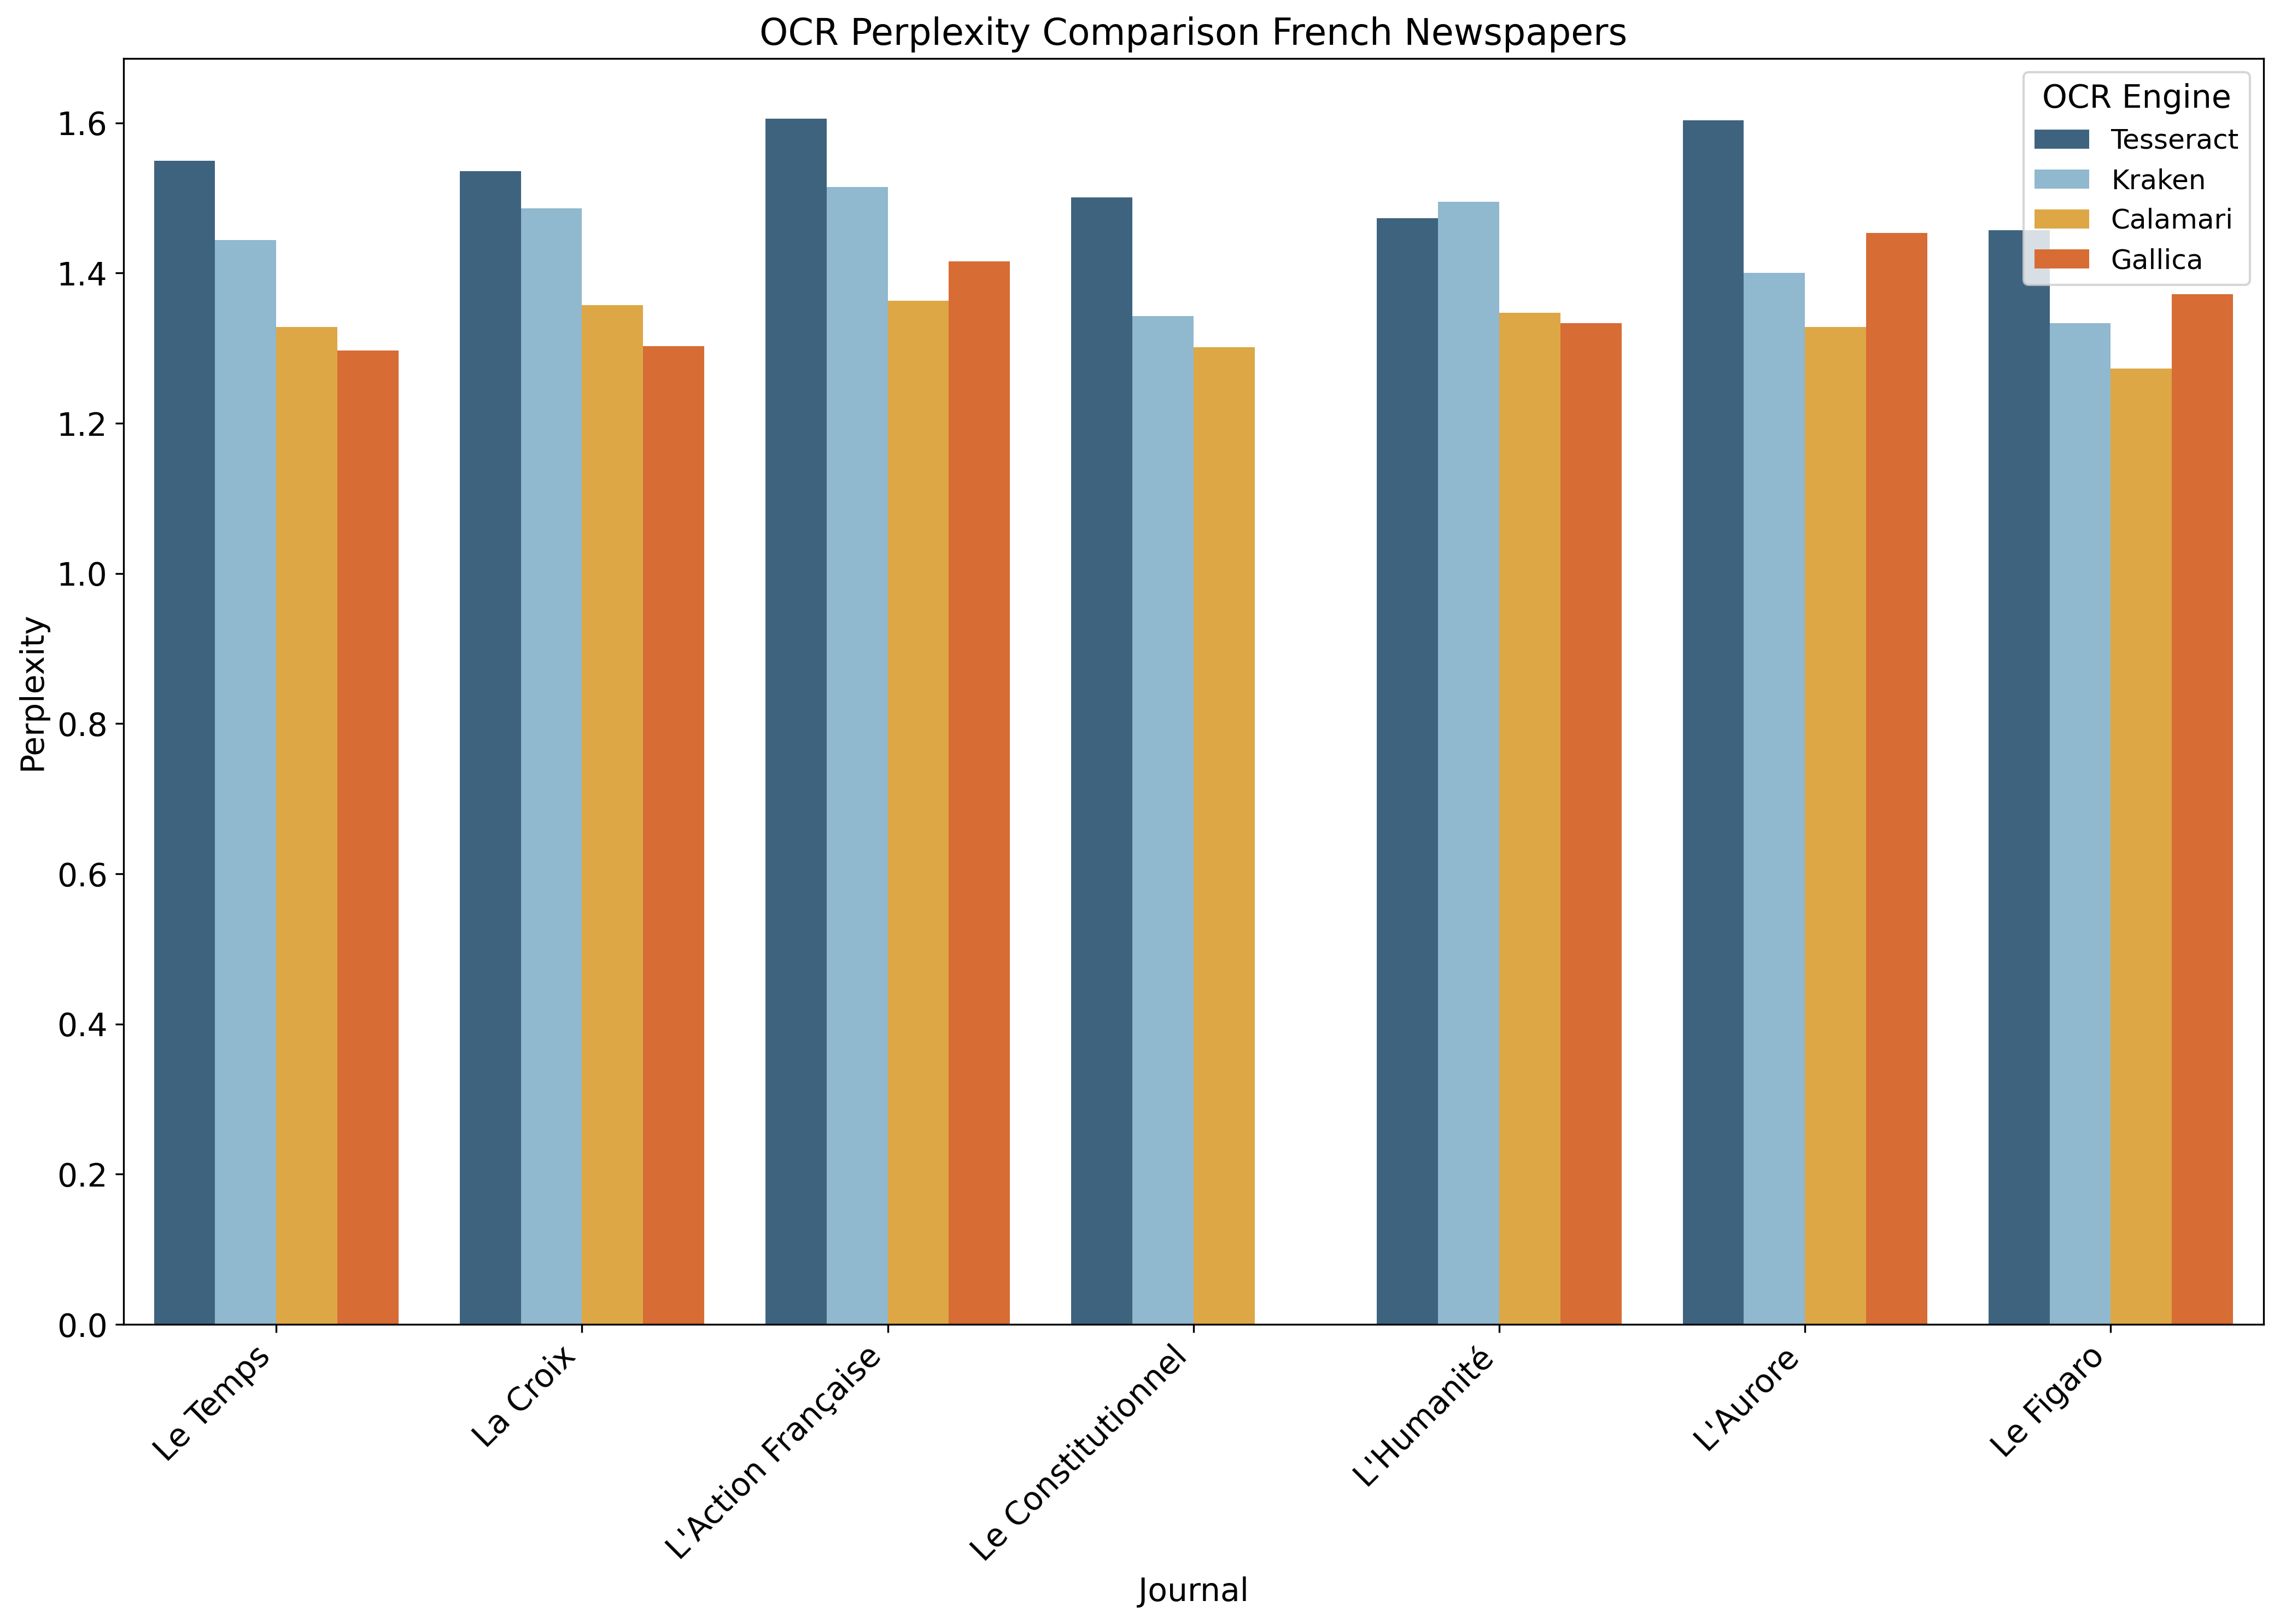

In [ ]:

long = (
    df                                  
    .melt(id_vars="file",
          value_vars=["perplexity_tesseract",
                      "perplexity_kraken",
                      "perplexity_calamari", "perplexity_gallica"],
          var_name="engine",
          value_name="perplexity")
    .assign(engine=lambda d: d.engine.str.replace(r"perplexity_", "", regex=True)
                                      .str.capitalize())  
)

palette = {"Tesseract": "#33658a",  
           "Kraken":     "#86bbd8",  
           "Calamari":   "#f6ae2d",  
           "Gallica":    "#f26419"}     

sns.barplot(data=long, x="file", y="perplexity",
            hue="engine", palette=palette)


labels = [textwrap.fill(f, width=25) for f in long["file"].unique()]
new_labels = ['Le Temps', 'La Croix',  'L\'Action Française', 'Le Constitutionnel', 'L\'Humanité', 'L\'Aurore', 'Le Figaro']
plt.xticks(ticks=range(len(labels)), labels=new_labels, rotation=45, ha="right")


plt.legend(title="OCR Engine", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Journal", fontsize=14)
plt.ylabel("Perplexity", fontsize=14)
plt.title("OCR Perplexity Comparison French Newspapers", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
labels = [textwrap.fill(f, width=25) for f in long["file"].unique()]
new_labels = ['Le Temps', 'La Croix',  'L\'Action Française', 'Le Constitutionnel', 'L\'Humanité', 'L\'Aurore', 'Le Figaro']
plt.xticks(ticks=range(len(labels)), labels=new_labels, rotation=45, ha="right")


['Le_Temps_',
 'La_Croix_Groupe_Bayard',
 "L'Action_française___orga\nne_du_[...]Action_françai\nse",
 'Le_Constitutionnel___jour\nnal_politique_[...]',
 'L_Humanite___journal_soci\naliste_quotidien_Parti_co\nmmuniste',
 "L'Aurore___littéraire_art\nistique_sociale_[...]",
 'Le_Figaro___journal_litté\nraire_[...]']

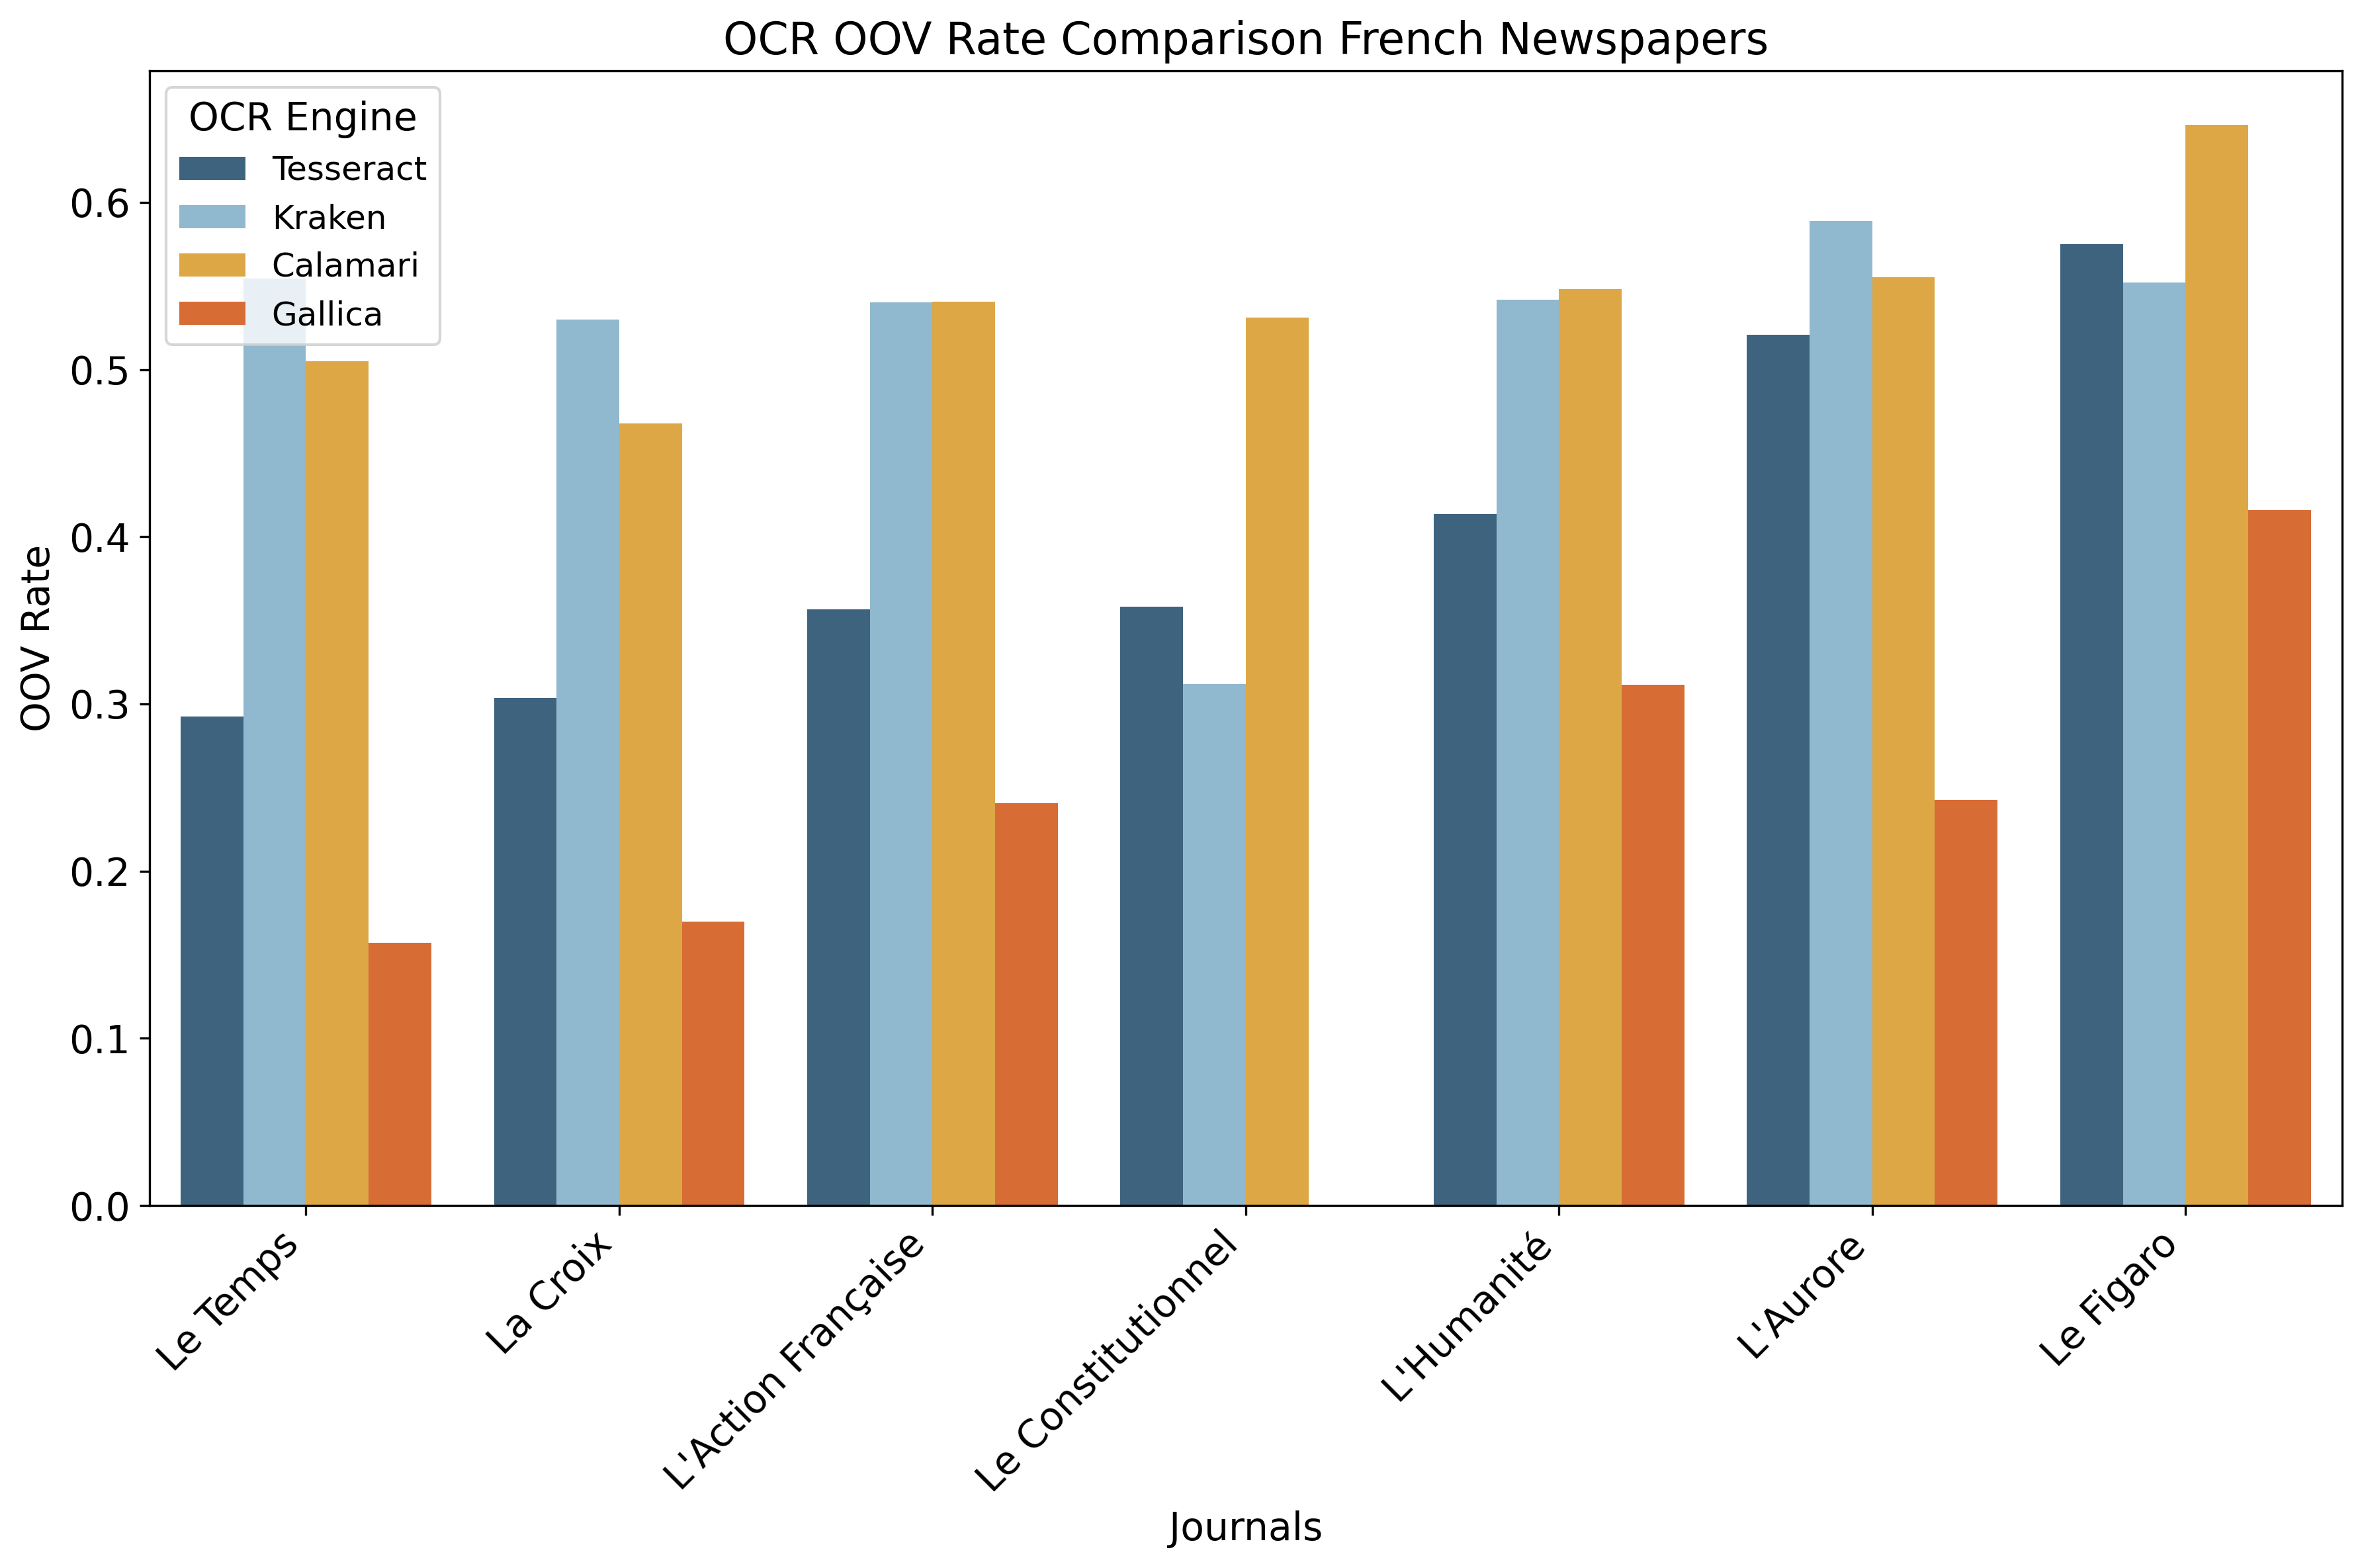

In [ ]:

df = df.sort_values("oov_tesseract")

long = (
    df                                 
    .melt(id_vars="file",
          value_vars=["oov_tesseract",
                      "oov_kraken",
                      "oov_calamari", "oov_gallica"],
          var_name="engine",
          value_name="oov_rate")
    .assign(engine=lambda d: d.engine.str.replace(r"oov_", "", regex=True)
                                      .str.capitalize())  
)

palette = {"Tesseract": "#33658a",  
           "Kraken":     "#86bbd8",  
           "Calamari":   "#f6ae2d",  
           "Gallica":    "#f26419"
        }     

plt.figure(figsize=(12, 8), dpi=300)
sns.barplot(data=long, x="file", y="oov_rate",
            hue="engine", palette=palette)

labels = [textwrap.fill(f, width=25) for f in long["file"].unique()]
new_labels = ['Le Temps', 'La Croix',  'L\'Action Française', 'Le Constitutionnel', 'L\'Humanité', 'L\'Aurore', 'Le Figaro']
plt.xticks(ticks=range(len(labels)), labels=new_labels, rotation=45, ha="right")

plt.legend(title="OCR Engine", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.xlabel("Journals", fontsize=14)
plt.ylabel("OOV Rate", fontsize=14)
plt.title("OCR OOV Rate Comparison French Newspapers", fontsize=16)
plt.tight_layout()
plt.show()


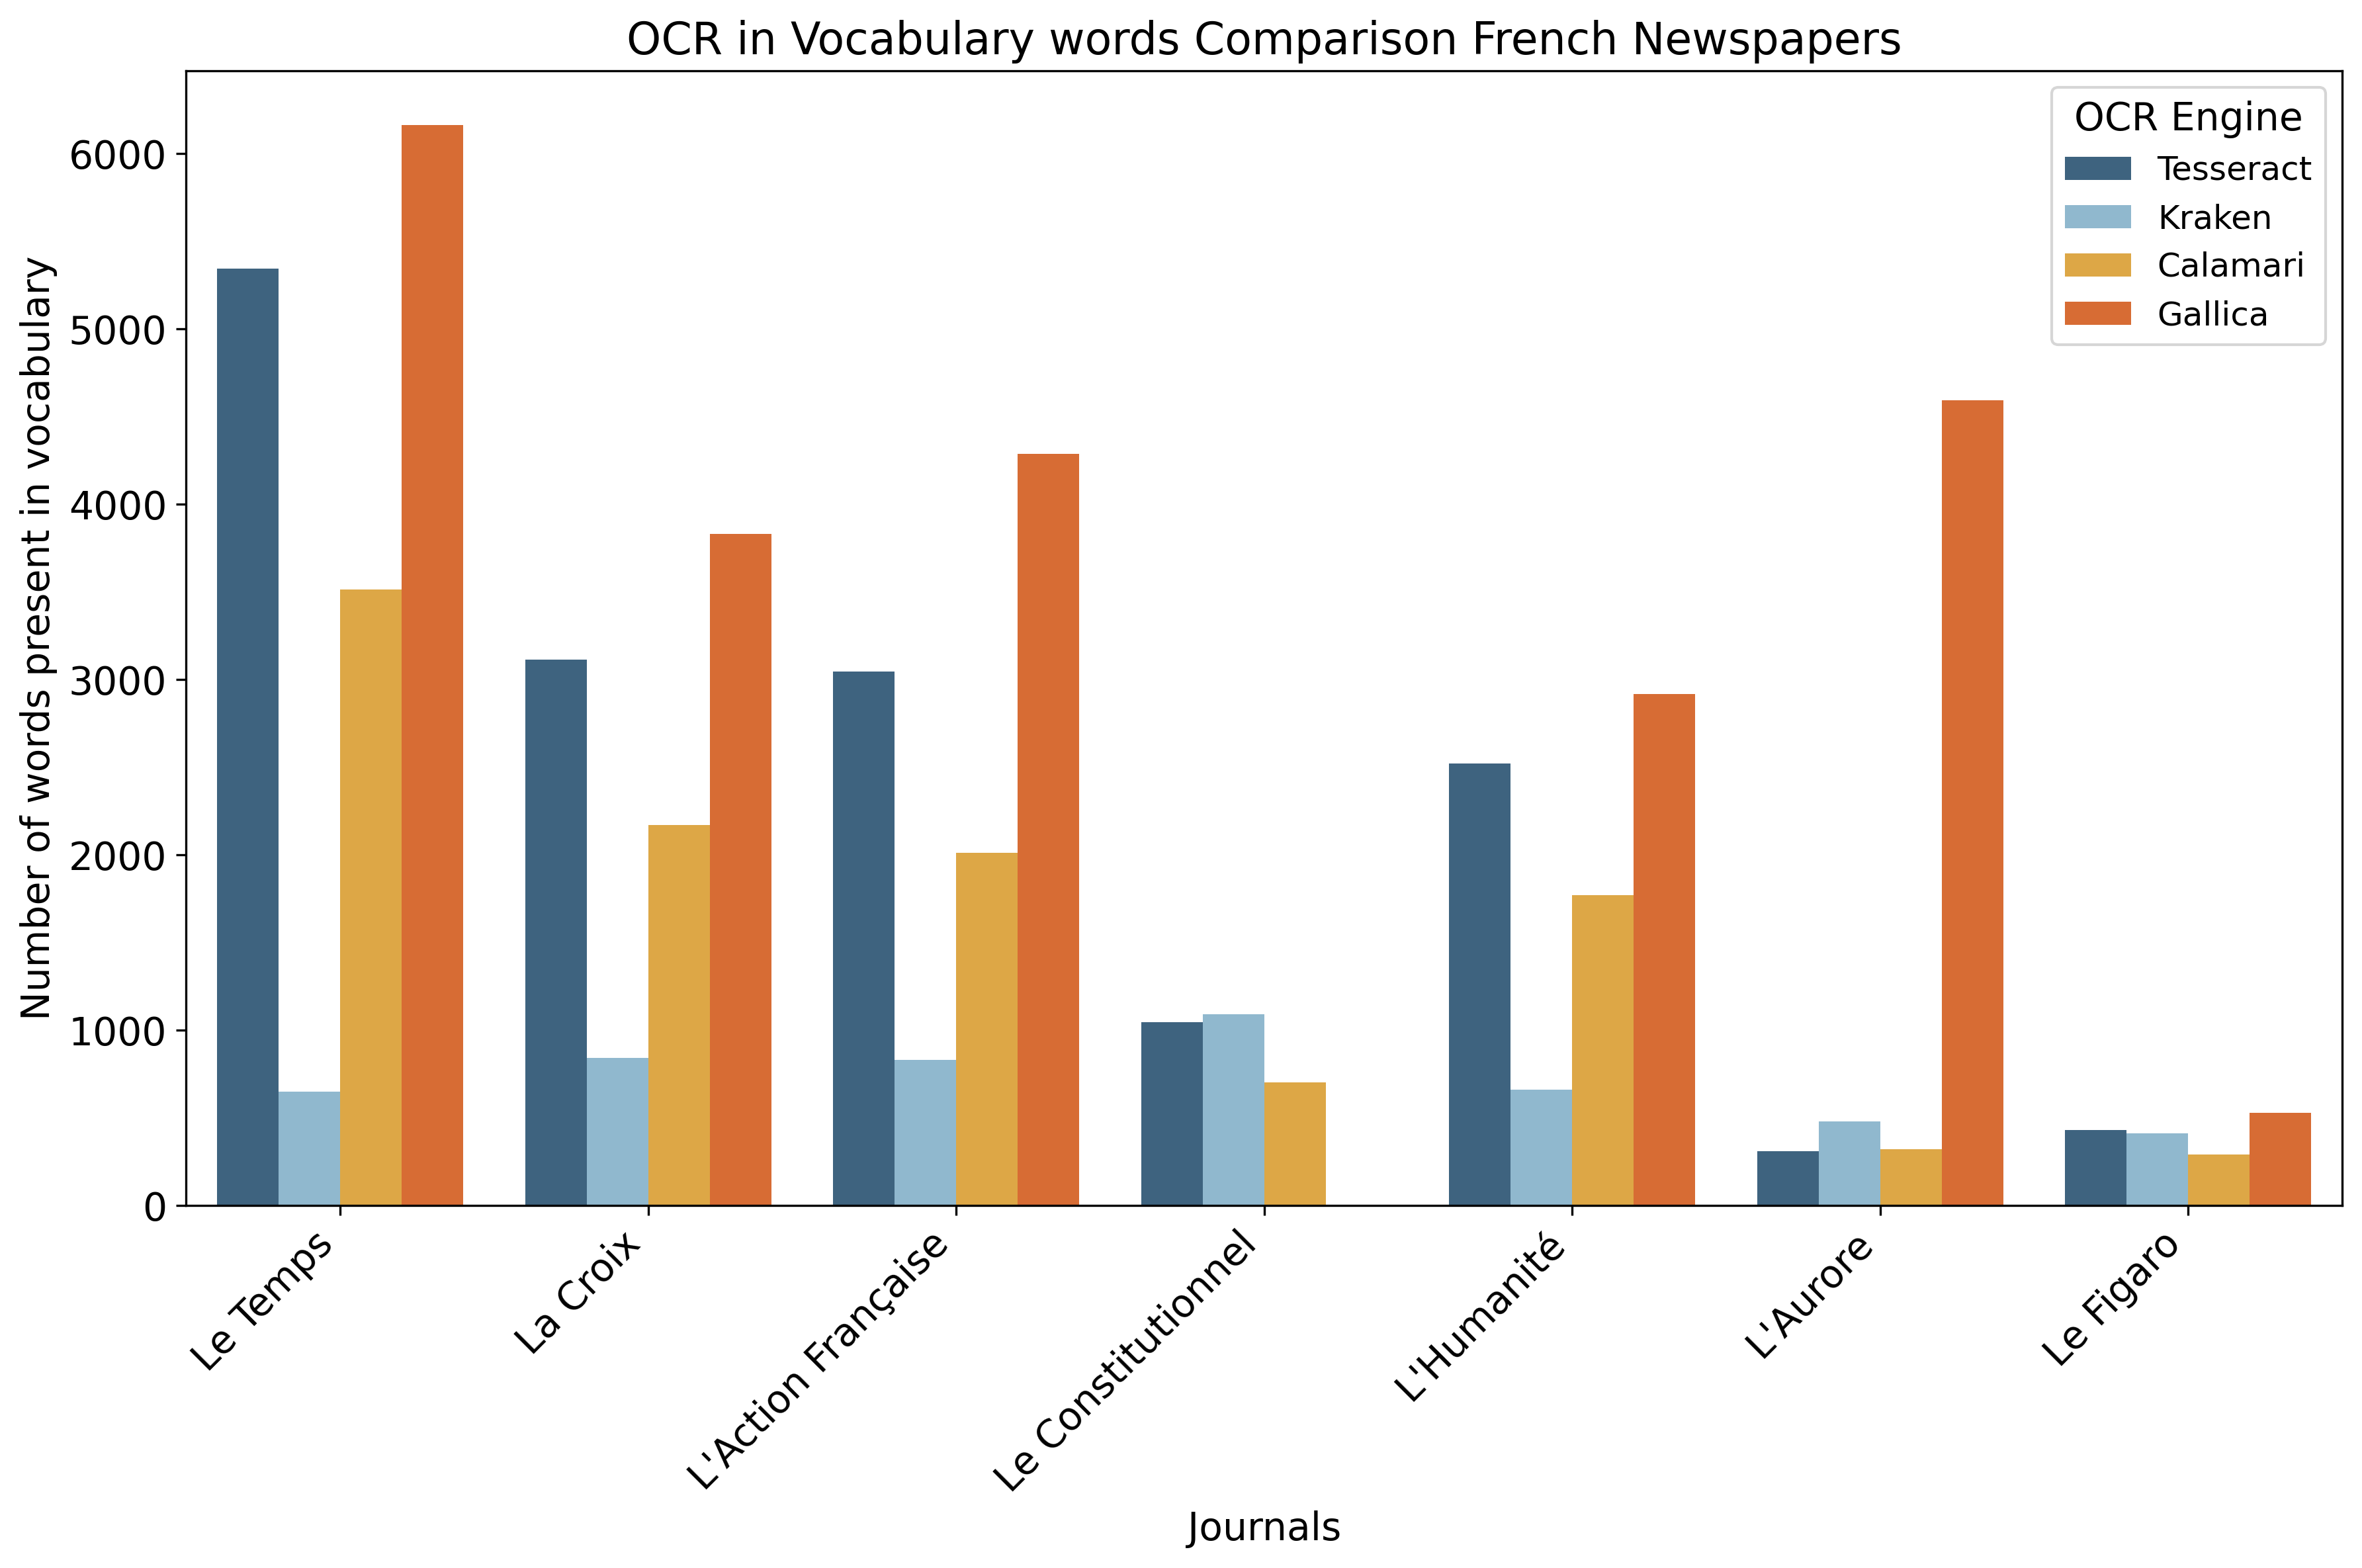

In [ ]:
#visualize results
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
df = df.sort_values("oov_tesseract")
# ───────────────────────────────────────────────────────────────
# 1   reshape wide → long
# ───────────────────────────────────────────────────────────────
long = (
    df                                   # columns: file, iv_tesseract …
    .melt(id_vars="file",
          value_vars=["iv_tesseract",
                      "iv_kraken",
                      "iv_calamari", "iv_gallica"],
          var_name="engine",
          value_name="iv_rate")
    .assign(engine=lambda d: d.engine.str.replace(r"iv_", "", regex=True)
                                      .str.capitalize())  # nicer labels
)

# consistent colours for the three engines
palette = {"Tesseract": "#33658a",  
           "Kraken":     "#86bbd8",  
           "Calamari":   "#f6ae2d",  
           "Gallica":    "#f26419"
        }     

# ───────────────────────────────────────────────────────────────
# 2   plot
# ───────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=300)
sns.barplot(data=long, x="file", y="iv_rate",
            hue="engine", palette=palette)

# wrap long file names so labels don’t collide
labels = [textwrap.fill(f, width=25) for f in long["file"].unique()]
new_labels = ['Le Temps', 'La Croix',  'L\'Action Française', 'Le Constitutionnel', 'L\'Humanité', 'L\'Aurore', 'Le Figaro']
plt.xticks(ticks=range(len(labels)), labels=new_labels, rotation=45, ha="right")

plt.legend(title="OCR Engine", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.xlabel("Journals", fontsize=14)
plt.ylabel("Number of words present in vocabulary", fontsize=14)
plt.title("OCR in Vocabulary words Comparison French Newspapers", fontsize=16)
plt.tight_layout()
plt.show()
